In [1]:
!pip install open3d numpy matplotlib pillow torch opencv-python ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.6 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.0/872.0 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 92.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
# @title Imports and Drive mount

import cv2
import random
import os
import shutil
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
from random import randint, choice, uniform
from scipy.ndimage import maximum_filter
from datetime import datetime
from IPython.display import Javascript
from pathlib import Path
from ultralytics import YOLO
from google.colab import output, drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# @title Parameter Config

#-------------------------------------------------------------------------------
#                            DIRECTORY PARAMETERS
#-------------------------------------------------------------------------------

# Path to this file
PATH = "/content/drive/MyDrive/MSC PROJECT/"

# When set to true, the directory, model and training data of the previous
# session will be used instead.
USE_PREVIOUS_MODEL = False

#-------------------------------------------------------------------------------
#                             ENCODING PARAMETERS
#-------------------------------------------------------------------------------

# Default encoding methods: Height, Height Difference, Point Count
# Encoding methods need to exist as functions in LidarEncoder.ipynb
ENCODE_TYPE = 0

ENCODE_METHODS = {
    0 : "Height",
    1 : "Height Difference",
    2 : "Point Count"
}

# Point count encoding localised normalisation radius [Default: 128]
LOC_NORM_RADIUS = 128

# Scale of image relative to the pointcloud [Default: 10]
IMG_SCALE = 10

#-------------------------------------------------------------------------------
#                              MODEL PARAMETERS
#-------------------------------------------------------------------------------

# Files that will be segmented and be detected on
FILES_TO_DETECT = ["L004",
                   "L003",
                   "L002",
                   "L001"]

# Size of segments to feed into model for detection [Default: 512]
SEGMENT_SIZE = 512

# Overlap between segments [Default: 0.1]
OVERLAP = 0.1

# Number of epochs to run model training. [Default: 500]
# [To work around small training set, this will be set high for forced overfit]
EPOCHS = 500

# Number of epochs to early stop after no improvement.
# [Overfitting is needed here, so we disable early stopping by setting to 0]
PATIENCE = 0

#-------------------------------------------------------------------------------
#                      TRAIN DATA GENERATION PARAMETERS
#-------------------------------------------------------------------------------

# Height and width of training/validation samples generated and used by model
TRAIN_SIZE = 128

# Number of variations of samples generated using various augmentation methods
AUGMENTATION_VARIATIONS = 10

# Classes that the DATA dictionary refers to for its ids
CLASSES = {
    0 : "Telepole",
    1 : "Hybrid"
}

# Coordinate locations of the objects to be detected, keys are the file name,
# coordinates refer to the 2D images generated (not pointcloud coordinates)
DATA = {
    "L003" : {
        "coordinates" : [
            (1503, 1200),
            (1151, 2346),
            (963, 2950)
            ],
        "ids" : [1, 1, 0]
    },
    "L004" : {
        "coordinates" : [
            (1007, 2709),
            (1258, 1884),
            (1561, 1312),
            (1501, 1641),
            (1625, 984)
            ],
        "ids" : [1, 1, 1, 0, 0]
    }
}

In [4]:
# @title Image Visualisation

def display_images(image_list, title_list=None):
    """
    Displays a list of images in a single row with optional titles.

    Parameters:
    -----------
    image_list : list
        A list of images to be displayed. Each image should be in a format
        that can be handled by `matplotlib.pyplot.imshow()`.

    title_list : list, optional
        A list of titles corresponding to each image in `image_list`. If
        provided, each image will be displayed with its associated title.
        If not provided, no titles will be displayed.

    Returns:
    --------
    None
    """
    num_images = len(image_list)

    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

    if num_images == 1:
        axes = [axes]

    for i, image in enumerate(image_list):
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(title_list[i])

    plt.show()

In [5]:
# @title Init Setup
%cd $PATH

%run TeleFinder.ipynb

%run LidarEncoder.ipynb

%run TrainingDataGen.ipynb

if USE_PREVIOUS_MODEL:
    with open("Latest_Model.txt", "r") as file:
        formatted_date_str = file.read()

else:
    js_code = """
    var now = new Date();
    now.toLocaleString();
    """
    date_obj = datetime.strptime(output.eval_js(js_code), "%m/%d/%Y, %I:%M:%S %p")
    formatted_date_str = date_obj.strftime("%Y-%m-%d_%H-%M-%S")


    os.makedirs(f"Outputs/{formatted_date_str}/Labeled Images", exist_ok=True)
    print(f"Created output directory: {formatted_date_str}")

    shutil.rmtree("dataset/labels")
    shutil.rmtree("dataset/images")

    directories = [
        "labels/train",
        "labels/val",
        "images/train",
        "images/val"
    ]

    for directory in directories:
        path = os.path.join("dataset", directory)
        os.makedirs(path, exist_ok=True)
    print("Reset training/validation dataset directory")

    with open("Latest_Model.txt", "w") as file:
        file.write(f"{formatted_date_str}")

/content/drive/MyDrive/MSC PROJECT
Created output directory: 2024-09-02_15-16-22
Reset training/validation dataset directory


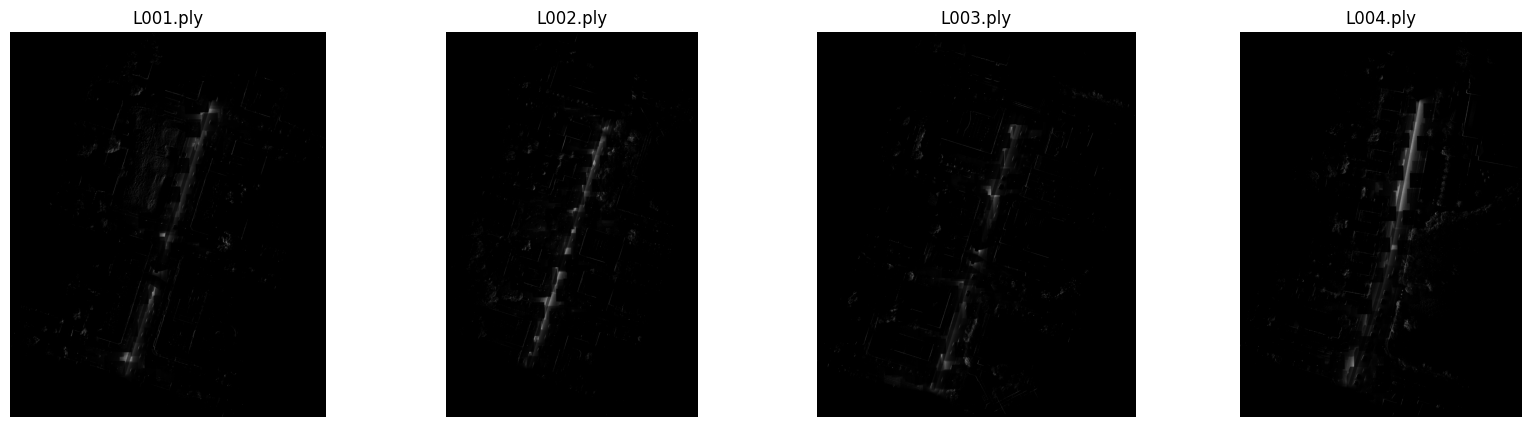

In [ ]:
# @title Encode Lidar Data To 2D Image

# Run this to encode pointclouds into 2D BEV images.
# Choose encoding method based on defined methods in config
# Each time this is run, the results are overwritten in the processed images folder.
display_images(
    *encode_images(
        image_scale = IMG_SCALE,
        local_normalisation_radius = LOC_NORM_RADIUS,
        encode_type = ENCODE_METHODS[ENCODE_TYPE]
))

In [6]:
# @title Generate Training/Validation Data

# Generates a training and validation dataset based on coordinates and IDs given
# in the config section. Each coordinate generates a number of augmented variations
# to bolster the training set, the original data is used as validation.
# Each time this is run, the result is overwritten [per session basis]

display_images(
    *generate_train_data(
        data = DATA,
        classes = CLASSES,
        encode_type = ENCODE_METHODS[ENCODE_TYPE],
        augmentation_variations = AUGMENTATION_VARIATIONS,
        train_size = TRAIN_SIZE
))

In [ ]:
# @title Train Model

# Running this begins training the model, requires training data to exist.
# Recommended to use a high epoch value for over fitting to a smaller dataset
# Each time this is run, the model is overwritten [per session basis]

train_model(
    save_dir = formatted_date_str,
    epochs = EPOCHS,
    train_size = TRAIN_SIZE,
    patience = PATIENCE
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov5nu.pt, data=dataset/dataset.yaml, epochs=500, time=None, patience=0, batch=1, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=Outputs/2024-09-02_15-16-22, name=Telefinder_Model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 115MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

/usr/local/lib/python3.10/dist-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /content/drive/My Drive/MSC PROJECT/dataset/labels/train... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 308.82it/s]


train: New cache created: /content/drive/My Drive/MSC PROJECT/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/MSC PROJECT/dataset/labels/val... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 207.05it/s]

val: New cache created: /content/drive/My Drive/MSC PROJECT/dataset/labels/val.cache


Plotting labels to Outputs/2024-09-02_15-16-22/Telefinder_Model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to Outputs/2024-09-02_15-16-22/Telefinder_Model
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500     0.268G    0.02167     0.3026   0.005455          1        128: 100%|██████████| 50/50 [00:04<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all          5          5          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      0.13G    0.07856     0.3441    0.02154          0        128: 100%|██████████| 50/50 [00:03<00:00, 16.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 35.01it/s]

                   all          5          5          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500     0.122G   1.53e-05     0.2871  8.577e-06          1        128:  84%|████████▍ | 42/50 [00:02<00:00, 16.14it/s]

In [ ]:
# @title Run detections

# Running this feeds all the encoded images through the model for detection
# Each time this is run, labeled images and coordinate dump are overwritten
# [per session basis]

display_images(
    *run_detections(
        save_dir = formatted_date_str,
        classes = CLASSES,
        file_list = FILES_TO_DETECT,
        encode_type = ENCODE_METHODS[ENCODE_TYPE],
        seg_size = SEGMENT_SIZE,
        overlap = OVERLAP
))